## Import libraries and Read in Data
2 files - Daily Stock price data, Sector mapping file

# PowerAI 5.1 Environment support - py2 / tflow 1.5 / xxx


In [1]:
ENV="dustinsmac" # dustinsmac / nimbix
if(ENV == "dustinsmac") : 
    rootdir = "/data/work/git-repos/mldl-101/labxx-eigenportfolios/"
    rootdir1 = "/data/work/osa/2018-04-eigenportfolios/Deep-Portfolio-Theory/"
else :
    rootdir = "/data/mldl-101/labxx-eigenportfolios/"

In [2]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

Using TensorFlow backend.


In [3]:
# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

# Data Columns we will work with
keep_cols = ['date', 'close']

#ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
# A,1999-11-18,45.5,50.0,40.0,44.0,44739900.0,0.0,1.0,31.041951216877,34.112034304261,27.289627443409,30.018590187749,44739900.0
# A,1999-11-19,42.94,43.0,39.81,40.38,10897100.0,0.0,1.0,29.295415060499,29.336349501664,27.160001713052,27.548878904121,10897100.0

full_price_df = pd.read_csv(rootdir + "WIKI_PRICES.csv",header=0)
full_price_df = full_price_df[keep_cols + ['ticker']]
#full_price_df = pd.read_csv(rootdir + "WIKI_PRICES.10000.csv")



In [4]:
# Set time ranges
# For Cross validation implement K-fold
INSAMPLE_START_DATE = '2015-01-01'
INSAMPLE_END_DATE = '2016-06-30'
CV_START_DATE = '2016-07-01'
CV_END_DATE = '2016-12-31'

OUTSAMPLE_START_DATE = '2017-01-01'
OUTSAMPLE_END_DATE = '2018-04-01'

In [5]:
# Add Indexes
ibb = pd.read_csv(rootdir1 + "./IBB.csv")
ivv = pd.read_csv(rootdir1 + "./IVV.csv")

def clean_idx(idx, name) :
    idx = idx.rename(index=str, columns={"Date": "date", "Open": "open", 
  "High": "high", "Low": "low", "Close": "close", "Adj Close" : "adj_close"})
    idx = idx[keep_cols]
    idx['ticker'] = name
    return idx

ibb = clean_idx(ibb, 'ibb')
ivv = clean_idx(ivv, 'ivv')


In [6]:
full_price_df = full_price_df.append([ibb,ivv])

In [7]:
full_price_df[full_price_df['ticker'] == 'ivv'].count()

date      4546
close     4546
ticker    4546
dtype: int64

In [8]:
#price_df = pd.read_csv("/data/mldl-101/labxx-eigenportfolios/WIKI_PRICES.10000.csv")
sectors_df = pd.read_csv(rootdir + "snp_sectors.csv")
sectors_df.head(1)

,Tickersymbol,Security,SECfilings,GICSSector,GICSSubIndustry,AddressofHeadquarters,Datefirstadded,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740


In [9]:
#IVV Constituents [from Ishares.com]
ivv_constituents_df = pd.read_csv(rootdir1 + "./IVV_holdings.csv")
ivv_constituents_df = ivv_constituents_df.set_index("Ticker")
ivv.head(2)
ivv_constituents_list = ivv_constituents_df.index.values.tolist()

In [10]:
# Add IBB Index to 

a = ['ibb' , 'ivv']
pd.DataFrame(a, columns=['ticker'])

,ticker
0,ibb
1,ivv


In [11]:
# join on price_df and ibb_constituents by ticker to filter ...
def get_stock_df(df, stock_list, start, end, mode='return', valuetype='close') :
    
    stock_list_df = pd.DataFrame(stock_list, columns=['ticker']).set_index('ticker')
    print("Index Top5" + stock_list_df.head(5))
    price_df = df.join(stock_list_df,how="inner",on='ticker')
    # Print a summary of counts per ticker
    
    # price_df.agg({'ticker' : ['count']})
    # price_df.groupby(['ticker']).agg( ['count'])

    # Type conversion for date column.  Just adding a new column called dt
    price_df['dt'] = pd.to_datetime(price_df.date, unit='ns') # 
    #print(ibb_price_df.dtypes)

    ## Keep data within date range
    # For now use data from 2017 up through present
    price_df = price_df[price_df.dt > start]
    price_df = price_df[price_df.dt < end]
    
    # reshape pandas array .  Here lets just grab the closing value...
    price_pvt_df = price_df.pivot(index='dt', values=valuetype, columns='ticker')
    ## Create daily return dataframe using pandas convenience function..
    df = None 
    if(mode == 'return') :
        # price levels
        df = price_pvt_df.pct_change()
    elif(mode == 'levels') :
        # returns
        df = price_pvt_df
    else :
        print("Usage error : Provide Mode with 'return' or 'levels'")
        print("Returning nothing") 
        df = None
    # drop columns with 3 or more NaN
    #ibb_daily_return_df.dropna(axis=1, thresh=3, inplace=True)

    # impute NaN
    # Imputer not doing what I want .... just set return to 0 so you dont get crazy outliers ...

    df = df.fillna(0)
    
    return df

In [12]:
ivv_daily_return_df    = get_stock_df(full_price_df, ivv_constituents_list, INSAMPLE_START_DATE, INSAMPLE_END_DATE, mode='return')
ivv_daily_return_cvdf = get_stock_df(full_price_df, ivv_constituents_list, CV_START_DATE, CV_END_DATE, mode='return')


Empty DataFrame
Columns: []
Index: [AAPL, MSFT, AMZN, FB, JPM]
Empty DataFrame
Columns: []
Index: [AAPL, MSFT, AMZN, FB, JPM]


In [13]:
for i in range(len(ivv_daily_return_cvdf.columns)) :
    if(ivv_daily_return_df.columns[i] != ivv_daily_return_cvdf.columns[i]) :
        print(ivv_daily_return_cvdf.columns[i] + "idx" + str(i))
        break

FTVidx188


In [14]:
ivv_daily_return_cvdf = ivv_daily_return_cvdf.drop(ivv_daily_return_cvdf.columns[188],axis=1)


In [15]:
ivv_daily_return_cvdf.head()

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,...,WDC,WEC,WFC,WHR,WLTW,WM,WMB,WMT,WRK,WU,WY,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS,ivv
dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-07-06,0.016457,-0.020048,0.001613,0.005685,0.023417,0.010329,0.014659,0.035243,0.003714,0.004750,0.001806,0.004052,0.001179,0.009965,0.003030,0.000186,0.006496,0.002459,0.004511,0.009930,0.004153,0.000976,0.003103,-0.001053,0.006730,...,0.016547,-0.002583,0.009522,0.015004,0.011257,0.002087,0.017422,0.009297,0.010259,0.002614,0.014141,0.009315,0.009360,0.001325,0.011798,-0.001975,0.011503,0.009493,0.008658,0.016503,0.013608,0.015256,0.023464,0.012421,0.005724
2016-07-07,-0.001124,0.037037,-0.001982,0.004292,0.000947,-0.002463,0.018754,0.012981,-0.007223,-0.000420,0.008835,0.000000,0.000856,0.008282,0.010763,-0.020829,-0.013891,-0.010630,-0.039671,-0.010940,0.004346,0.010925,-0.008175,-0.011475,0.002716,...,0.048394,-0.019345,0.003215,0.008773,-0.003444,0.001190,-0.004403,-0.003928,-0.006948,-0.009385,0.000664,-0.010786,-0.014510,-0.022281,0.000921,0.005057,-0.012010,-0.003825,0.006438,0.001097,0.001663,0.001971,0.017507,-0.008318,-0.000854
2016-07-08,0.023863,0.021769,0.023087,0.007713,0.011509,0.011483,0.005461,0.012814,0.021384,0.017343,0.031993,0.032289,0.010374,0.018912,0.030077,0.009497,0.006118,0.018182,0.013250,0.014982,0.010840,0.022964,0.014480,0.023810,0.014583,...,0.035460,0.010096,0.021154,0.020848,0.004982,0.004756,0.031450,0.004216,0.037406,0.030000,0.017585,0.008880,0.031800,0.006092,0.011956,0.027565,0.006239,0.014240,0.017058,0.017094,0.017198,0.023521,0.013519,0.016985,0.015190
2016-07-11,-0.001759,0.037284,-0.007037,0.003103,0.002961,0.003174,0.015681,0.005491,0.003041,0.003616,0.008833,-0.007360,0.007092,0.046925,0.006347,-0.003951,-0.000141,0.018669,-0.004786,0.002345,-0.009601,0.005282,0.004172,0.005091,0.005749,...,0.002634,-0.001845,0.006068,0.007819,0.003678,0.001479,-0.012387,0.002979,0.008301,0.001533,0.018585,0.048468,-0.006839,-0.004037,-0.004544,0.005323,0.003742,0.005521,-0.004193,0.012497,0.007929,0.001521,0.007680,-0.004330,0.003788


In [16]:
#ibb_idx_daily_return_df = get_daily_returns(full_price_df, ibb_idx_df, INSAMPLE_START_DATE, INSAMPLE_END_DATE)
ivv_idx_df = pd.DataFrame(ivv_daily_return_df['ivv'])
ivv_daily_return_df = ivv_daily_return_df.drop(columns=['ivv'])
ivv_daily_return_df.head(2)

ivv_idx_cvdf = pd.DataFrame(ivv_daily_return_cvdf['ivv'])
ivv_daily_return_cvdf = ivv_daily_return_cvdf.drop(columns=['ivv'])
ivv_daily_return_cvdf.head(2)
print(ivv_daily_return_df.shape)
print(ivv_daily_return_cvdf.shape)


(376, 487)
(126, 487)


In [17]:
# Find outliers ....
# ibb_daily_return_df[ibb_daily_return_df > 0.5] = 0.0 # null out outliers ....
# ibb_daily_return_df = ibb_daily_return_df[ibb_daily_return_df > 0.5]
# ibb_daily_return_df.stack()

## Plot some series

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

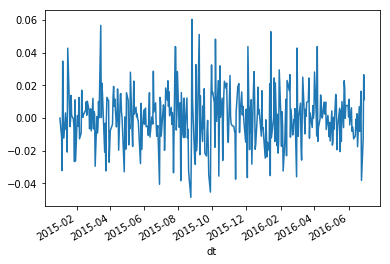

In [19]:
plt.figure()
ivv_daily_return_df.AMGN.plot()
#daily_return_df.AAMC.plot()
#daily_return_df.IBM.plot()

#daily_return_df.S1.plot()
#daily_return_df.S11.plot()
#daily_return_df.S2.plot()
#daily_return_df.S3.plot()


In [20]:
# plot distribution of returns
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

/Users/dustinvanstee/.virtualenvs/cssc_env36_tf18/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


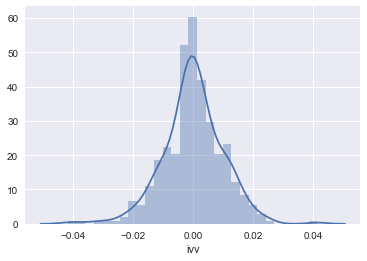

In [21]:
#sns.distplot(ivv_daily_return_df.AMGN)
sns.distplot(ivv_idx_df.ivv)



In [22]:
ivv_daily_return_df.describe()

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,...,WBA,WDC,WEC,WFC,WHR,WLTW,WM,WMB,WMT,WRK,WU,WY,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
count,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,...,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000
mean,0.000312,-0.001485,0.000209,-0.000248,0.000031,-0.000343,0.003485,-0.000288,0.000703,0.000838,0.000178,-0.000448,0.000252,-0.000834,-0.000088,0.000423,0.000383,-0.000169,0.000988,0.000433,-0.000087,-0.000134,0.000457,0.000700,0.000022,...,0.000378,-0.001986,0.000572,-0.000310,-0.000252,-0.000058,0.000645,-0.000930,-0.000360,-0.001140,0.000251,-0.000446,-0.000655,0.000600,0.000580,-0.000102,0.000245,0.000089,0.000533,-0.000875,0.000446,0.000539,0.000231,-0.000131,0.000387
std,0.014822,0.023769,0.018270,0.016849,0.020039,0.012290,0.036070,0.015147,0.013595,0.016120,0.018785,0.017157,0.012007,0.019303,0.020527,0.011888,0.011989,0.018792,0.017924,0.011638,0.021082,0.013890,0.013775,0.015198,0.010755,...,0.016594,0.026931,0.012102,0.013787,0.019076,0.009570,0.009795,0.047254,0.013612,0.020925,0.015676,0.015230,0.035292,0.025895,0.011285,0.012289,0.016369,0.014125,0.013026,0.019504,0.012868,0.018921,0.012746,0.019932,0.017650
min,-0.054841,-0.108144,-0.154261,-0.065707,-0.103288,-0.074623,-0.285859,-0.092908,-0.062737,-0.082909,-0.078109,-0.087422,-0.042075,-0.193679,-0.084998,-0.049634,-0.052842,-0.086876,-0.065226,-0.049155,-0.147721,-0.072930,-0.067288,-0.134135,-0.046468,...,-0.107293,-0.118311,-0.049318,-0.050398,-0.090772,-0.083353,-0.049362,-0.348131,-0.100405,-0.149179,-0.068661,-0.067988,-0.166386,-0.103947,-0.049255,-0.087005,-0.087012,-0.047276,-0.045320,-0.133393,-0.062237,-0.188324,-0.047685,-0.101918,-0.122066
25%,-0.008498,-0.013335,-0.006843,-0.008452,-0.010587,-0.006214,-0.012381,-0.006728,-0.006888,-0.007667,-0.008655,-0.009112,-0.005841,-0.008675,-0.010660,-0.005971,-0.005770,-0.011946,-0.008988,-0.005858,-0.011690,-0.007887,-0.007146,-0.006789,-0.005921,...,-0.008346,-0.016169,-0.005441,-0.007342,-0.009871,0.000000,-0.004294,-0.017600,-0.006708,-0.006342,-0.008427,-0.008591,-0.019247,-0.015106,-0.005581,-0.006301,-0.008652,-0.007676,-0.007607,-0.010464,-0.007047,-0.007232,-0.007311,-0.011532,-0.009151
50%,0.000683,0.000243,0.000512,-0.000152,0.000571,0.000658,0.001242,0.000000,0.000877,0.001341,-0.000563,0.000565,0.000345,0.000704,0.000000,0.000833,0.001302,0.000757,0.001848,0.000941,-0.000979,0.000249,0.001471,0.001166,0.000323,...,-0.000299,-0.000416,0.000805,-0.000358,-0.000487,0.000000,0.000941,0.000000,-0.000139,0.000000,-0.000485,0.000000,-0.003469,-0.000142,0.001143,0.000584,0.000443,-0.000196,0.000874,0.000000,-0.000115,0.000209,0.000239,0.000000,0.000000
75%,0.009996,0.012011,0.008228,0.008784,0.010015,0.006166,0.019015,0.008399,0.007474,0.009946,0.008701,0.008856,0.007001,0.008888,0.010030,0.008127,0.007802,0.011013,0.011593,0.006964,0.011371,0.007268,0.008726,0.008987,0.005768,...,0.009419,0.012704,0.008896,0.007704,0.010319,0.000000,0.006240,0.016552,0.006589,0.004060,0.008914,0.007430,0.015290,0.016915,0.008638,0.006313,0.008919,0.007237,0.008350,0.010240,0.008589,0.009652,0.007463,0.011964,0.008937
max,0.042647,0.069096,0.111417,0.057355,0.100739,0.041760,0.292778,0.042617,0.067566,0.054543,0.101462,0.054821,0.058215,0.067263,0.097873,0.032939,0.029517,0.057490,0.046229,0.035456,0.078183,0.049089,0.034417,0.075905,0.038631,...,0.063478,0.144587,0.027639,0.047609,0.073100,0.036684,0.051667,0.343865,0.095804,0.114692,0.064143,0.051770,0

In [23]:
## Now lets flip this analysis on its head !!!
ivv_tp_df = ivv_daily_return_df.transpose()
ivv_tp_df.head()
#ivv_tp_cvdf = ivv_daily_return_cvdf.transpose()

dt,2015-01-02 00:00:00,2015-01-05 00:00:00,2015-01-06 00:00:00,2015-01-07 00:00:00,2015-01-08 00:00:00,2015-01-09 00:00:00,2015-01-12 00:00:00,2015-01-13 00:00:00,2015-01-14 00:00:00,2015-01-15 00:00:00,2015-01-16 00:00:00,2015-01-20 00:00:00,2015-01-21 00:00:00,2015-01-22 00:00:00,2015-01-23 00:00:00,2015-01-26 00:00:00,2015-01-27 00:00:00,2015-01-28 00:00:00,2015-01-29 00:00:00,2015-01-30 00:00:00,2015-02-02 00:00:00,2015-02-03 00:00:00,2015-02-04 00:00:00,2015-02-05 00:00:00,2015-02-06 00:00:00,...,2016-05-25 00:00:00,2016-05-26 00:00:00,2016-05-27 00:00:00,2016-05-31 00:00:00,2016-06-01 00:00:00,2016-06-02 00:00:00,2016-06-03 00:00:00,2016-06-06 00:00:00,2016-06-07 00:00:00,2016-06-08 00:00:00,2016-06-09 00:00:00,2016-06-10 00:00:00,2016-06-13 00:00:00,2016-06-14 00:00:00,2016-06-15 00:00:00,2016-06-16 00:00:00,2016-06-17 00:00:00,2016-06-20 00:00:00,2016-06-21 00:00:00,2016-06-22 00:00:00,2016-06-23 00:00:00,2016-06-24 00:00:00,2016-06-27 00:00:00,2016-06-28 00:00:00,2016-06-29 00:00:00
ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,0.0,-0.018738,-0.015578,0.013272,0.029975,-0.007337,-0.011826,-0.013962,-0.012389,-0.026882,0.006314,-0.008366,0.006064,0.039046,-0.021185,0.008761,-0.010217,-0.019355,0.012105,-0.017941,0.024358,0.024037,-0.012872,0.010739,-0.004806,...,0.008661,0.001982,0.006812,0.001528,0.001307,-0.001088,-0.003922,0.003062,-0.002399,0.008743,-0.001300,-0.015839,-0.009700,-0.000223,0.000668,0.009568,-0.000220,0.017196,0.000433,-0.002816,0.014121,-0.054841,-0.042158,0.020114,0.015078
AAL,0.0,-0.000649,-0.015499,-0.000566,0.012262,-0.030563,-0.046905,0.016539,-0.019643,0.000000,0.008096,0.059024,0.017441,0.035774,0.001799,-0.004310,-0.049684,-0.039378,0.032003,-0.060490,-0.007335,-0.025041,0.041263,-0.013142,-0.013624,...,0.000622,-0.020516,0.004443,0.008215,0.001254,-0.008764,-0.027155,0.014606,0.035189,0.004635,0.027376,-0.007784,-0.040435,-0.045283,0.004282,-0.044277,0.006863,0.012611,0.010434,-0.004330,0.014721,-0.108144,-0.065804,0.059359,0.034740
AAP,0.0,-0.013181,-0.000703,0.021489,0.008765,-0.005089,-0.008546,-0.032530,-0.019056,-0.018630,0.013377,0.017733,0.004520,0.020802,-0.004855,0.022147,-0.001256,0.001698,0.006026,-0.007862,-0.019057,0.007053,-0.003820,0.023583,0.011489,...,0.028057,0.020387,-0.002234,-0.015802,-0.003250,-0.007761,-0.009464,-0.003119,0.009784,0.011931,0.021235,-0.023983,-0.003071,0.000524,0.006617,0.001953,0.003963,0.006665,-0.007327,-0.008288,0.011557,-0.002646,-0.004789,0.020809,0.025672
AAPL,0.0,-0.028172,0.000094,0.014022,0.038422,0.001072,-0.024641,0.008879,-0.003811,-0.027140,-0.007770,0.025757,0.007634,0.026016,0.005160,0.001062,-0.035013,0.056533,0.031133,-0.014634,0.012547,0.000169,0.007670,0.003178,-0.008421,...,0.017569,0.007930,-0.000598,-0.004883,-0.014020,-0.007516,0.002047,0.007251,0.004056,-0.000909,0.007176,-0.008229,-0.015076,0.001233,-0.003283,0.004221,-0.022758,-0.002413,0.008517,-0.003754,0.005756,-0.028096,-0.014561,0.016841,0.008655
ABBV,0.0,-0.018819,-0.004950,0.040417,0.010459,-0.027355,-0.000304,-0.036040,0.004890,-0.012716,0.026236,-0.016889,-0.011820,0.004466,-0.008733,0.006407,0.004297,-0.019810,0.020534,-0.043885,0.005800,0.015651,-0.076886,0.018977,-0.018796,...,0.008567,0.011107,0.013086,0.003508,-0.001589,0.035970,-0.001383,-0.033538,0.004457,-0.021712,-0.015876,0.004115,-0.017541,-0.000501,0.008347,0.008278,-0.014614,0.001666,-0.002163,0.006836,0.015234,-0.023650,-0.019713,0.022324,0.030338


### Play with Kfold here ...

In [24]:
idx = np.array([0,2])
ivv_tp_df.iloc[idx,:]
type(idx)

numpy.ndarray

In [54]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2)
for train_index, test_index in kf.split(ivv_tp_df):
    #print(type(train_index))
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = ivv_tp_df.iloc[train_index,:], ivv_tp_df.iloc[test_index,:]
    print(X_train.head())
    #y_train, y_test = y[train_index], y[test_index]


dt      2015-01-02  2015-01-05  2015-01-06  2015-01-07  2015-01-08  \
ticker                                                               
JBHT           0.0   -0.016403   -0.017227   -0.001616    0.011829   
JCI            0.0   -0.015134   -0.010943    0.016008    0.019231   
JEC            0.0   -0.036066   -0.018127   -0.013254    0.035980   
JNJ            0.0   -0.006984   -0.004914    0.022076    0.007863   
JNPR           0.0   -0.011136   -0.013964    0.022385    0.029044   

dt      2015-01-09  2015-01-12  2015-01-13  2015-01-14  2015-01-15  \
ticker                                                               
JBHT     -0.005538   -0.011632    0.002629   -0.020854   -0.001658   
JCI      -0.006138   -0.010293    0.002080   -0.011531   -0.004900   
JEC      -0.026858   -0.030217   -0.012267   -0.009190   -0.033342   
JNJ      -0.013629   -0.003431    0.001721   -0.007255   -0.014519   
JNPR      0.000868   -0.026030   -0.002227   -0.006696   -0.038652   

dt      2015-01-16

### Phase 1 : Encode
### Build an auto-encoder


In [28]:
from sklearn.model_selection import KFold
#TODO : add experiment for batch size

NUMSPLITS=4
kf = KFold(n_splits=NUMSPLITS)

for idx, (train_index, test_index) in enumerate(kf.split(ivv_tp_df)):
    print("idx={}, len={}".format(idx, len(train_index), len(test_index)))


num_tspoints = len(ivv_tp_df.columns) # Use 488 stocks as features
network_experiments = []
network_experiments.append( [25]) # Auto-encoder layers
network_experiments.append( [50]) # Auto-encoder layers
network_experiments.append( [100]) # Auto-encoder layers
network_experiments.append( [100,25,100]) # Auto-encoder layers
network_experiments.append( [100,25,5,25,100]) # Auto-encoder layers
network_experiments.append( [250,50,25,50,250]) # Auto-encoder layers

regularization = [0.000001, 0.0001, 0.01, 1] # , 0.000001, 0.0001, 0.01, 1
global_recon_error = 99999

# Large Loop to test all sorts of hyper parameters for an auto-encoder
for encoding_dims in network_experiments:
    print("Working on " + str(encoding_dims))
    for r in regularization :
        input_layer = Input(shape=(num_tspoints, ))
        layer = []
        layer.append(input_layer)
        #encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
        for l in range(len(encoding_dims)) :
            layer.append (Dense(encoding_dims[l], activation='relu', kernel_regularizer=regularizers.l2(r))(layer[l]) )
        
        # see 'Stacked Auto-Encoders' in paper
        decoded = Dense(num_tspoints, activation= 'linear', kernel_regularizer=regularizers.l2(r))(layer[-1]) 
        
        
        # construct and compile AE model
        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer='sgd', loss='mean_squared_error')
        
        # train autoencoder
        ## TODO - Add Kfold loop here!
        recon_error = 0
        for kf_iter, (train_index, cv_index) in enumerate(kf.split(ivv_tp_df)):
    
            print("Inner Loop encoding_dim : {}, regular={}, kfold_iter={}".format(encoding_dims,r,kf_iter))
            X_train, X_CV = ivv_tp_df.iloc[train_index,:], ivv_tp_df.iloc[cv_index,:]
        
        
            ae_scaler = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
            ae_scaler.fit(X_train)
            x = ae_scaler.transform(X_train)  
        
            #data = stock['calibrate']['net']
            fit_err = autoencoder.fit(x, x, shuffle=False, epochs=500, batch_size = 20,verbose=False)
            loss = fit_err.history['loss'][-1]
        
            # Use cross val data for now .. and sum over all folds ...
            xcv = ae_scaler.transform(X_CV)  
            recon_kfold_err =  np.linalg.norm(autoencoder.predict(xcv)-xcv)
            recon_error = recon_error + recon_kfold_err
            print("Recon err = {} : Current Iter err = {}".format(recon_error,recon_kfold_err) )
        
        # Select Model that works best on CV data
        if(recon_error < global_recon_error) :
            print("New Model found! ")
            print("Best recon error = " + str(recon_error))
            print("best_regularization= " + str(r))
            print("best_encoding_dims= " + str(encoding_dims))
            global_recon_error = recon_error
            best_regularization = r
            best_encoding_dims = encoding_dims
            best_autoencoder = autoencoder

print("Best model settings : ")
print("Regularization = " + str(best_regularization))
print("Network = " + str(best_encoding_dims))

#autoencoder.save('model/retrack_autoencoder.h5')

# test/reconstruct market information matrix
#reconstruct = autoencoder.predict(data)

idx=0, len=365
idx=1, len=365
idx=2, len=365
idx=3, len=366
Working on [50]
Inner Loop encoding_dim : [50], regular=0.0001, kfold_iter=0
Recon err = 223.8460460636512 : Current Iter err = 223.8460460636512
Inner Loop encoding_dim : [50], regular=0.0001, kfold_iter=1
Recon err = 433.15153661249565 : Current Iter err = 209.30549054884446
Inner Loop encoding_dim : [50], regular=0.0001, kfold_iter=2
Recon err = 666.4964547638629 : Current Iter err = 233.34491815136718
Inner Loop encoding_dim : [50], regular=0.0001, kfold_iter=3
Recon err = 860.5951835840539 : Current Iter err = 194.098728820191
New Model found! 
Best recon error = 860.5951835840539
best_regularization= 0.0001
best_encoding_dims= [50]
Working on [100, 25, 5, 25, 100]
Inner Loop encoding_dim : [100, 25, 5, 25, 100], regular=0.0001, kfold_iter=0
Recon err = 230.5257695545627 : Current Iter err = 230.5257695545627
Inner Loop encoding_dim : [100, 25, 5, 25, 100], regular=0.0001, kfold_iter=1
Recon err = 459.54432721543674 : Cur

In [29]:
best_autoencoder.summary()
print(best_encoding_dims)
print(best_regularization)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 376)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                18850     
_________________________________________________________________
dense_10 (Dense)             (None, 376)               19176     
Total params: 38,026
Trainable params: 38,026
Non-trainable params: 0
_________________________________________________________________
[50]
0.0001


In [32]:
### Save Model for Future use ...
best_autoencoder.save("/tmp/best_ae")

In [ ]:
### Load Model 
keras.models.load_model(filepath)

### Cluster Based on the embedded layer ...

In [33]:
best_autoencoder.layers

In [27]:
outputs = [layer.output for layer in best_autoencoder.layers]

In [28]:
outputs[4]

<tf.Tensor 'dense_4/Relu:0' shape=(?, 25) dtype=float32>

In [34]:
embedded_ts = Model(input=best_autoencoder.input, outputs=best_autoencoder.get_layer('dense_9').output)

/Users/dustinvanstee/.virtualenvs/cssc_env36_tf18/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [35]:
embedded_ts.summary()
encode = embedded_ts.predict(x=ivv_tp_df)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 376)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                18850     
Total params: 18,850
Trainable params: 18,850
Non-trainable params: 0
_________________________________________________________________


In [36]:
encode[0]

array([0.05098282, 0.0670362 , 0.02756292, 0.02656353, 0.10766907,
       0.        , 0.1005016 , 0.08452801, 0.0594487 , 0.07809766,
       0.04340275, 0.00354818, 0.        , 0.05656314, 0.04869273,
       0.06632163, 0.0059229 , 0.03789842, 0.00557418, 0.12877941,
       0.06778642, 0.0759206 , 0.01462841, 0.        , 0.09942013,
       0.        , 0.        , 0.05688813, 0.        , 0.00053954,
       0.02422173, 0.12366973, 0.10048588, 0.07475305, 0.05040701,
       0.10834448, 0.00483406, 0.        , 0.02551216, 0.00247278,
       0.        , 0.        , 0.08258207, 0.01508158, 0.06466998,
       0.07109245, 0.10120307, 0.05220762, 0.06530556, 0.07170676],
      dtype=float32)

In [37]:
ticker_encode = pd.DataFrame(data=encode, index=ivv_tp_df.index)
ticker_encode

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,0.050983,0.067036,0.027563,0.026564,0.107669,0.000000,0.100502,0.084528,0.059449,0.078098,0.043403,0.003548,0.000000,0.056563,0.048693,0.066322,0.005923,0.037898,0.005574,0.128779,0.067786,0.075921,0.014628,0.000000,0.099420,0.000000,0.000000,0.056888,0.000000,0.000540,0.024222,0.123670,0.100486,0.074753,0.050407,0.108344,0.004834,0.000000,0.025512,0.002473,0.000000,0.000000,0.082582,0.015082,0.064670,0.071092,0.101203,0.052208,0.065306,0.071707
AAL,0.036379,0.061826,0.035060,0.094581,0.159255,0.000000,0.079961,0.104630,0.027476,0.056439,0.048694,0.000000,0.000000,0.126810,0.146345,0.040035,0.087696,0.163731,0.042199,0.103249,0.048401,0.190877,0.120293,0.004789,0.057506,0.000000,0.000000,0.070435,0.000000,0.000000,0.048915,0.103151,0.059056,0.058382,0.038449,0.034866,0.000000,0.000000,0.000000,0.024893,0.000000,0.000000,0.053354,0.058169,0.146634,0.048852,0.128462,0.031295,0.134350,0.079015
AAP,0.072257,0.069727,0.009411,0.026926,0.106380,0.000000,0.100872,0.135396,0.044968,0.113544,0.043164,0.021829,0.039447,0.126834,0.041839,0.061452,0.016648,0.072503,0.027496,0.063430,0.057880,0.084706,0.013261,0.000000,0.046765,0.000000,0.000000,0.021307,0.000000,0.013494,0.029398,0.154056,0.088284,0.083586,0.000000,0.087051,0.000000,0.000000,0.027505,0.050931,0.000000,0.023336,0.083978,0.000000,0.040762,0.044191,0.036304,0.079780,0.029087,0.039094
AAPL,0.062429,0.056058,0.019423,0.028000,0.084936,0.000000,0.153207,0.069701,0.040934,0.068199,0.048165,0.000000,0.000000,0.075622,0.085151,0.083672,0.003730,0.013066,0.038963,0.135331,0.027880,0.132539,0.000000,0.017132,0.050402,0.044475,0.000000,0.046639,0.000000,0.045993,0.011270,0.063297,0.115005,0.066557,0.019881,0.075206,0.000000,0.000000,0.000000,0.023779,0.000000,0.000000,0.070551,0.017734,0.067063,0.090763,0.074164,0.049881,0.068516,0.049755
ABBV,0.042673,0.111774,0.014348,0.008297,0.112657,0.002724,0.072468,0.115106,0.042913,0.115793,0.039693,0.006535,0.000000,0.082516,0.052846,0.053685,0.022564,0.065858,0.031412,0.107348,0.076489,0.097774,0.000000,0.006009,0.074522,0.000000,0.000000,0.039201,0.003382,0.000000,0.050993,0.101474,0.135747,0.071221,0.083742,0.053846,0.058995,0.000000,0.057279,0.017970,0.000000,0.034190,0.042292,0.001596,0.046270,0.082920,0.123276,0.025939,0.049848,0.031655
ABC,0.014399,0.070176,0.045049,0.020904,0.103222,0.001188,0.060982,0.070888,0.036533,0.090371,0.078735,0.032717,0.010194,0.069765,0.061395,0.055405,0.063676,0.048068,0.039143,0.095287,0.102164,0.079983,0.011021,0.017855,0.063020,0.000000,0.000000,0.025239,0.000000,0.000000,0.012335,0.092185,0.094437,0.058605,0.075830,0.087306,0.000000,0.000000,0.026980,0.000000,0.000000,0.000000,0.022345,0.021476,0.050135,0.074131,0.091696,0.065828,0.088466,0.033072
ABMD,0.000000,0.054323,0.000000,0.019898,0.069187,0.000000,0.095710,0.058832,0.085999,0.157913,0.000000,0.000000,0.000000,0.125993,0.153050,0.000387,0.005663,0.057842,0.262819,0.216273,0.162332,0.151051,0.000000,0.000000,0.085473,0.000000,0.038912,0.045037,0.000000,0.134231,0.000000,0.147641,0.097948,0.060920,0.059733,0.038482,0.134126,0.000000,0.000000,0.000000,0.035167,0.000000,0.025582,0.000000,0.065876,0.077354,0.168127,0.223272,0.195937,0.004559
ABT,0.040433,0.072914,0.016975,0.020359,0.131708,0.000000,0.089838,0.080542,0.042536,0.106753,0.051795,0.034399,0.000000,0.070418,0.055949,0.063106,0.024161,0.079764,0.034357,0.106357,0.069268,0.080554,0.000000,0.000000,0.060944,0.000000,0.000000,0.043546,0.000000,0.000000,0.022915,0.129905,0.103319,0.044268,0.051697,0.101153,0.004769,0.000000,0.004102,0.000000,0.000000,0.000000,0.060160,0.000000,0.047317,0.098515,0.091481,0.052777,0.063869,0.042893
ACN,0.068499,0.031013,0.032434,0.020708,0.069891,0.000000,0.121720,0.071801,0.043416,0.078438,0.039623,0.010802,0.000000,0.076433,0.057082,0.077168,0.010718,0.042078,0.0

Text(0.5,1,'Kmeans Elbow Analysis')

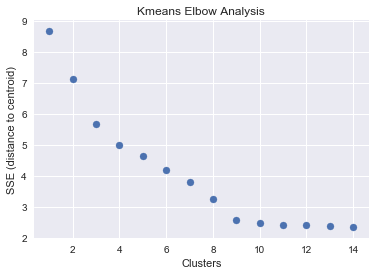

In [122]:
from sklearn.cluster import KMeans
import numpy as np
X = ticker_encode
num_clusters=9

kmmdl = []
km_inertia = []

for i in range(1,15) :
    kmmdl.append(KMeans(n_clusters=i, random_state=2, max_iter=1000, n_init=20).fit(ticker_encode))
    km_inertia.append(kmmdl[i-1].inertia_)            

plt.figure()
plt.scatter(x=range(1,15),y=np.log(km_inertia))
plt.xlabel("Clusters")
plt.ylabel("log(SSE) (distance to centroid)")
plt.title("Kmeans Elbow Analysis")
 

In [123]:
num_clusters = 9
kmeans = kmmdl[num_clusters-1]
ticker_encode["cluster"] = kmeans.labels_

In [124]:
#sectors_df[sectors_df["GICSSector"] == 'Industrials']
#sectors_df["Tickersymbol"]

In [125]:
# Join with real sectors ..
join_tickers = ticker_encode.join(sectors_df.set_index('Tickersymbol'), how="inner")
join_tickers.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,cluster,Security,SECfilings,GICSSector,GICSSubIndustry,AddressofHeadquarters,Datefirstadded,CIK
A,0.050983,0.067036,0.027563,0.026564,0.107669,0.0,0.100502,0.084528,0.059449,0.078098,0.043403,0.003548,0.000000,0.056563,0.048693,0.066322,0.005923,0.037898,0.005574,0.128779,0.067786,0.075921,0.014628,0.000000,0.099420,...,0.074753,0.050407,0.108344,0.004834,0.0,0.025512,0.002473,0.0,0.000000,0.082582,0.015082,0.064670,0.071092,0.101203,0.052208,0.065306,0.071707,2,Agilent Technologies Inc,reports,Health Care,Health Care Equipment,"Santa Clara, California",6/5/00,1090872
AAL,0.036379,0.061826,0.035060,0.094581,0.159255,0.0,0.079961,0.104630,0.027476,0.056439,0.048694,0.000000,0.000000,0.126810,0.146345,0.040035,0.087696,0.163731,0.042199,0.103249,0.048401,0.190877,0.120293,0.004789,0.057506,...,0.058382,0.038449,0.034866,0.000000,0.0,0.000000,0.024893,0.0,0.000000,0.053354,0.058169,0.146634,0.048852,0.128462,0.031295,0.134350,0.079015,4,American Airlines Group,reports,Industrials,Airlines,"Fort Worth, Texas",3/23/15,6201
AAP,0.072257,0.069727,0.009411,0.026926,0.106380,0.0,0.100872,0.135396,0.044968,0.113544,0.043164,0.021829,0.039447,0.126834,0.041839,0.061452,0.016648,0.072503,0.027496,0.063430,0.057880,0.084706,0.013261,0.000000,0.046765,...,0.083586,0.000000,0.087051,0.000000,0.0,0.027505,0.050931,0.0,0.023336,0.083978,0.000000,0.040762,0.044191,0.036304,0.079780,0.029087,0.039094,1,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Roanoke, Virginia",7/9/15,1158449


In [126]:
# Print Per Sector Report
for i,s in enumerate(join_tickers['GICSSector'].unique()) :
    print("#################### Sector " + s + ":" +  str(i) + " ##############")
    print("cluster,count")
    print(join_tickers[join_tickers["GICSSector"] == s]['cluster'].value_counts())

# Print Per Cluster Report
for i in range(num_clusters) :
    print("#################### Cluster " + str(i) + " ##############")
    print(join_tickers[join_tickers["cluster"] == i]['GICSSector'].value_counts())

  

#################### Sector Health Care:0 ##############
cluster,count
4    37
1    19
2     4
Name: cluster, dtype: int64
#################### Sector Industrials:1 ##############
cluster,count
1    32
3    19
2     9
4     5
Name: cluster, dtype: int64
#################### Sector Consumer Discretionary:2 ##############
cluster,count
1    27
8    19
2    19
3    11
4     1
Name: cluster, dtype: int64
#################### Sector Information Technology:3 ##############
cluster,count
2    37
1    23
3     7
4     3
Name: cluster, dtype: int64
#################### Sector Consumer Staples:4 ##############
cluster,count
1    24
0     7
8     1
3     1
Name: cluster, dtype: int64
#################### Sector Utilities:5 ##############
cluster,count
0    26
7     1
3     1
Name: cluster, dtype: int64
#################### Sector Financials:6 ##############
cluster,count
5    36
1    22
2     7
3     1
Name: cluster, dtype: int64
#################### Sector Real Estate:7 ##############
cluster,co

In [119]:
#join_tickers[join_tickers["cluster"] == 1].index

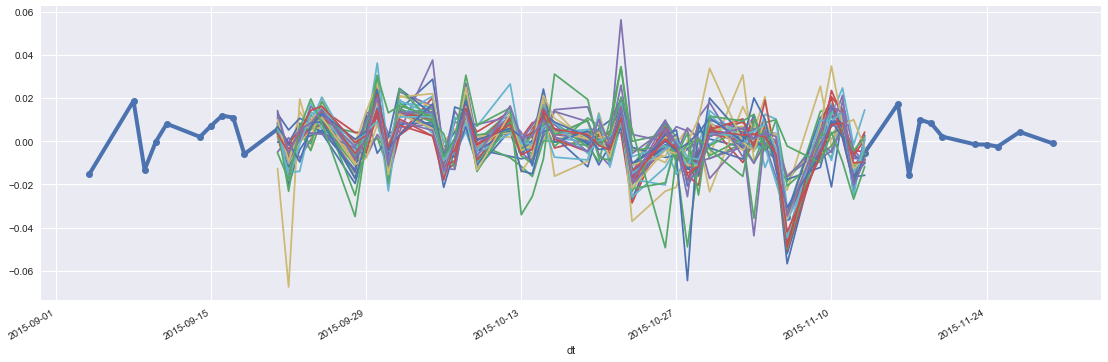

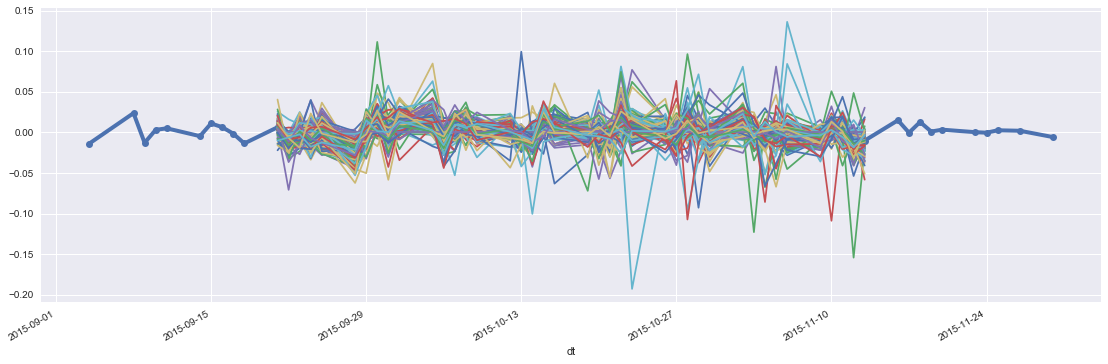

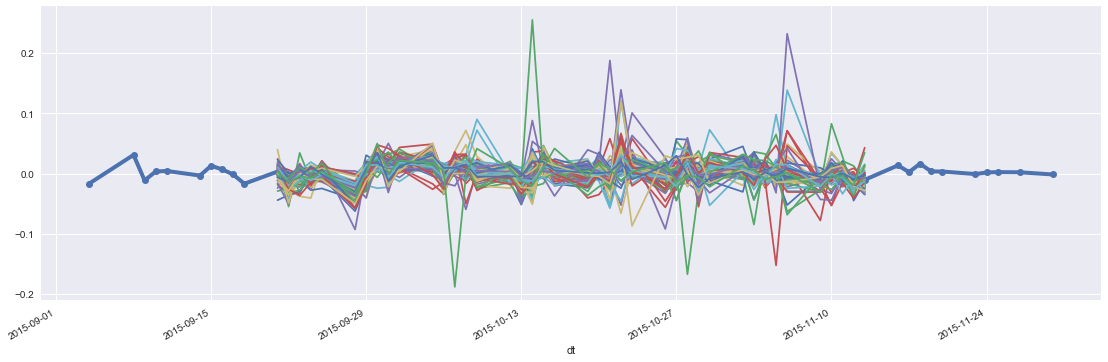

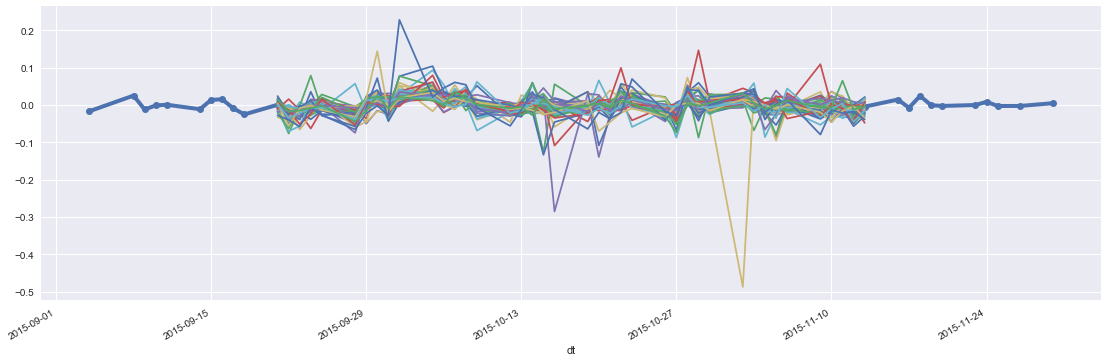

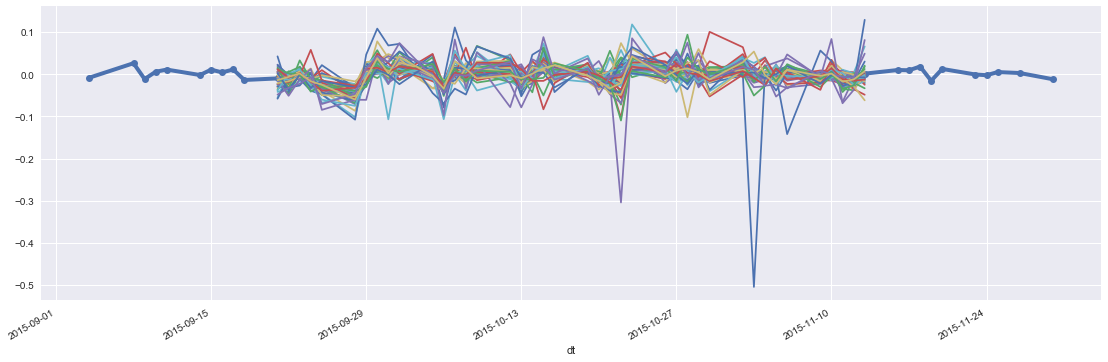

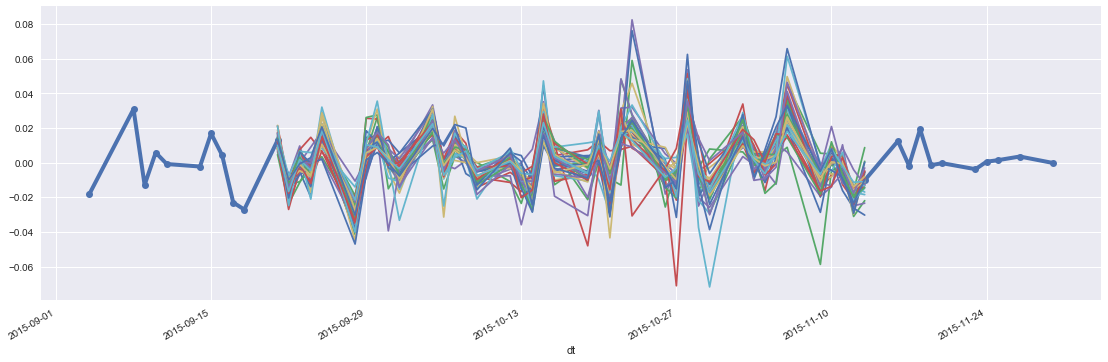

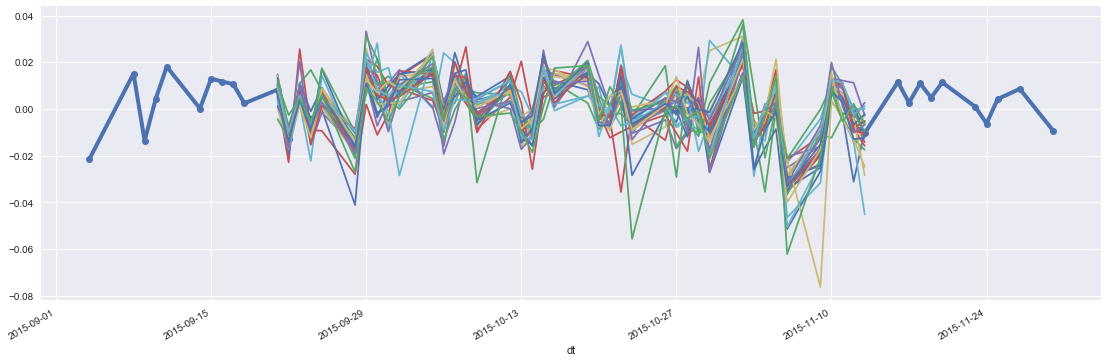

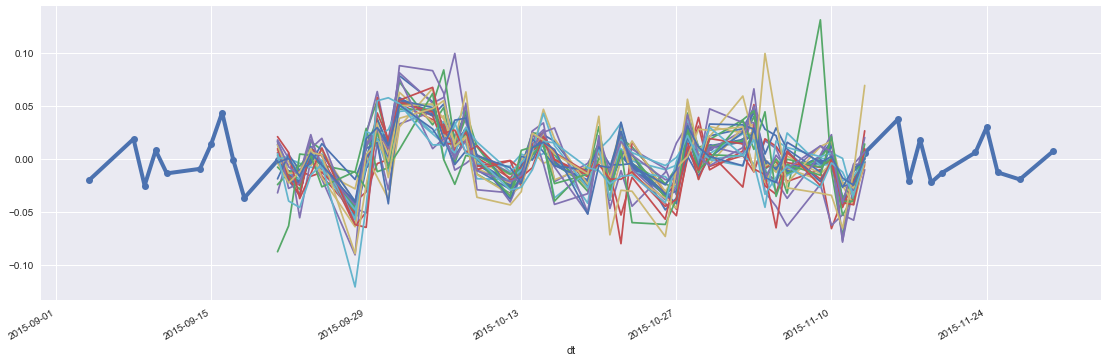

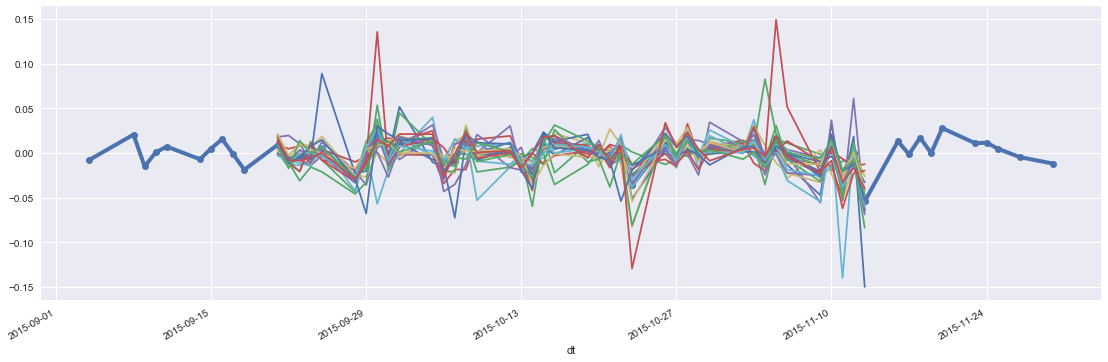

In [127]:

for j in range(num_clusters) :
    cluster_tickers = join_tickers[join_tickers["cluster"] == j].index.tolist()
    plt.figure()

    # Mean time series ...
    ivv_daily_return_df[cluster_tickers].mean(axis=1).iloc[170:230].plot(style='o-',linewidth=4)
    # Individual Series
    for i in cluster_tickers :
        ivv_daily_return_df[i].iloc[180:220].plot(figsize=(19,6))


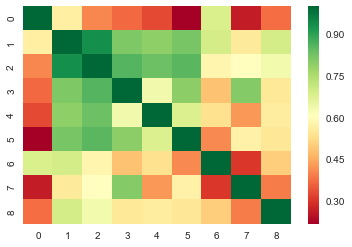

In [131]:
### Correlation Between cluster averages
cluster_mean_df = pd.DataFrame()
for j in range(num_clusters) :
    cluster_tickers = join_tickers[join_tickers["cluster"] == j].index.tolist()
    # Mean time series ...
    cluster_mean_df[j] = ivv_daily_return_df[cluster_tickers].mean(axis=1)
cluster_mean_df.corr()

import seaborn as sns

# plot the heatmap
sns.heatmap(cluster_mean_df.corr(), 
        xticklabels=cluster_mean_df.corr().columns,
        yticklabels=cluster_mean_df.corr().columns, cmap="RdYlGn")

In [51]:
### Build a Portfolio Based on the most representative 2 stocks from each cluster... 
# Verify how it tracks IVV

pandas.core.series.Series

In [133]:
my_portfolio = pd.DataFrame()
for j in range(num_clusters) :
    cluster_tickers = join_tickers[join_tickers["cluster"] == j].index.tolist()
    my_portfolio[cluster_tickers[0]] = ivv_daily_return_df[cluster_tickers[0]]
    
my_portfolio.head()

,AEE,AAP,A,ADM,AAL,AMG,AIV,APA,BBY
dt,,,,,,,,,
2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-05,-0.010002,-0.013181,-0.018738,-0.034602,-0.000649,-0.036259,0.008709,-0.061413,-0.025780
2015-01-06,-0.011641,-0.000703,-0.015578,-0.019713,-0.015499,-0.021548,0.008111,-0.010850,-0.008997
2015-01-07,0.007778,0.021489,0.013272,0.015031,-0.000566,0.024543,0.010122,-0.011137,0.028838
2015-01-08,0.003528,0.008765,0.029975,-0.014609,0.012262,0.010182,0.010791,0.038737,0.015053
